In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import random
import cv2
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve,auc
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc


In [22]:
# Define paths based on your new directory structure
train_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Train'
val_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Validation'
test_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Test'

In [23]:
# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
TRAIN_LIMIT = 1000  # Limit training images to 1000
VALIDATION_LIMIT = 150  # Limit validation images to 150
TEST_LIMIT = 150

In [24]:
# Function to limit data to a maximum number of images
def limit_data(directory, max_images):
    classes = os.listdir(directory)
    limited_dir = '/kaggle/working/limited_dataset'  # Temporary directory for limited dataset
    os.makedirs(limited_dir, exist_ok=True)
    
    for cls in classes:
        src_cls_path = os.path.join(directory, cls)
        dst_cls_path = os.path.join(limited_dir, cls)
        os.makedirs(dst_cls_path, exist_ok=True)
        
        all_images = os.listdir(src_cls_path)
        selected_images = random.sample(all_images, min(max_images, len(all_images)))
        
        for img in selected_images:
            src_path = os.path.join(src_cls_path, img)
            dst_path = os.path.join(dst_cls_path, img)
            if not os.path.exists(dst_path):
                os.symlink(src_path, dst_path)  # Use symbolic links to save space
    
    return limited_dir

# Limit datasets to specified sizes
train_dir_limited = limit_data(train_dir, TRAIN_LIMIT)
val_dir_limited = limit_data(val_dir, VALIDATION_LIMIT)
test_dir_limited = limit_data(test_dir, TEST_LIMIT)

In [25]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip=True,
    rotation_range=40,
    zoom_range=0.3,
    shear_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.8, 1.2],  # Adjust brightness
    fill_mode='nearest'
)


datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir_limited,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

valid_generator = datagen.flow_from_directory(
    val_dir_limited,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    test_dir_limited,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 7593 images belonging to 2 classes.
Found 7593 images belonging to 2 classes.
Found 7593 images belonging to 2 classes.


In [ ]:
# Unfreeze some layers
base_model.trainable = True
for layer in base_model.layers[:-50]:  # Keep earlier layers frozen
    layer.trainable = False


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)


In [ ]:
from tensorflow.keras.optimizers import AdamW

model.compile(optimizer=AdamW(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])


In [26]:
# Load the DenseNet121 base model
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model layers

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [27]:
# Define the model checkpoint to save the best model during training
checkpoint_path = "/kaggle/working/Best_Model.keras"  # Use .keras extension
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50,  # Adjust based on your requirements
    callbacks=[model_checkpoint]  # No early stopping included
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.6870 - loss: 0.6719
Epoch 1: val_accuracy improved from -inf to 0.76478, saving model to /kaggle/working/Best_Model.keras
475/475 ━━━━━━━━━━━━━━━━━━━━ 196s 357ms/step - accuracy: 0.6871 - loss: 0.6718 - val_accuracy: 0.7648 - val_loss: 0.4741
Epoch 2/50
474/475 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.7322 - loss: 0.5321
Epoch 2: val_accuracy improved from 0.76478 to 0.77269, saving model to /kaggle/working/Best_Model.keras
475/475 ━━━━━━━━━━━━━━━━━━━━ 105s 217ms/step - accuracy: 0.7322 - loss: 0.5321 - val_accuracy: 0.7727 - val_loss: 0.4663
Epoch 3/50
474/475 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.7528 - loss: 0.5000
Epoch 3: val_accuracy improved from 0.77269 to 0.77637, saving model to /kaggle/working/Best_Model.keras
475/475 ━━━━━━━━━━━━━━━━━━━━ 104s 217ms/step - accuracy: 0.7528 - loss: 0.5000 - val_accuracy: 0.7764 - val_loss: 0.4594
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.7610

In [28]:
# Optionally, load the best model
model.load_weights(checkpoint_path)

In [29]:
# Plot training & validation loss and accuracy
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

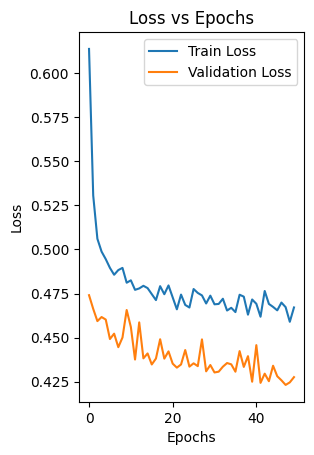

In [30]:
# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

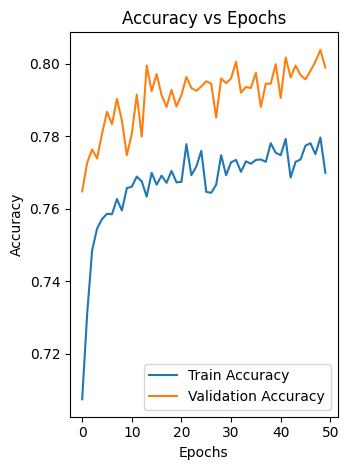

In [31]:
# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

475/475 ━━━━━━━━━━━━━━━━━━━━ 39s 67ms/step


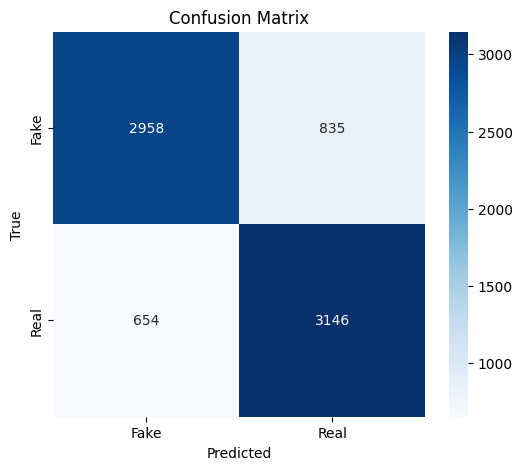

In [32]:
# Get the true labels from the test generator
y_true = test_generator.classes

# Get model predictions (probabilities)
y_pred_prob = model.predict(test_generator)

# Convert probabilities to class labels (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      3793
           1       0.79      0.83      0.81      3800

    accuracy                           0.80      7593
   macro avg       0.80      0.80      0.80      7593
weighted avg       0.80      0.80      0.80      7593

Precision: 0.79
Recall: 0.83
F1-Score: 0.81


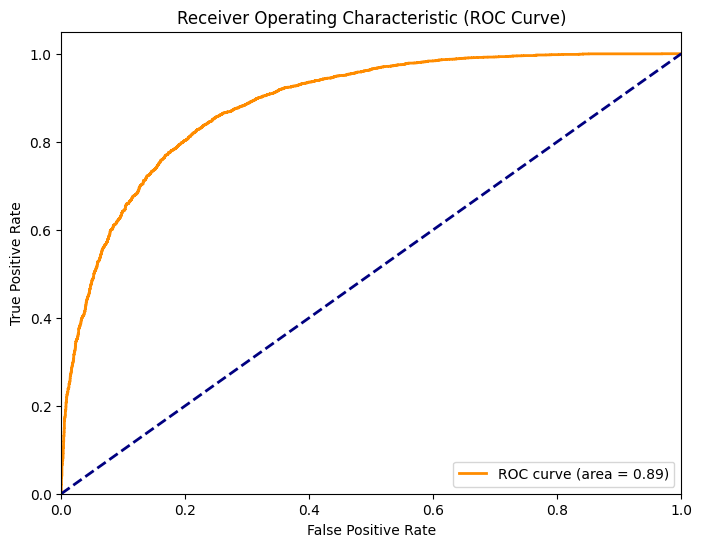

In [33]:
# Print Classification Report (Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Calculate Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC Curve)')
plt.legend(loc="lower right")
plt.show()



In [ ]:
# Optionally, save the final model (optional)
model.save('/kaggle/working/Final_Model.keras')

Found 10002 images belonging to 2 classes.
Found 10002 images belonging to 2 classes.
Found 10002 images belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/626 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.5954 - loss: 0.8070
Epoch 1: val_accuracy improved from -inf to 0.73655, saving model to /kaggle/working/Best_Model.keras
626/626 ━━━━━━━━━━━━━━━━━━━━ 207s 299ms/step - accuracy: 0.5955 - loss: 0.8068 - val_accuracy: 0.7366 - val_loss: 0.5435 - learning_rate: 1.0000e-04
Epoch 2/50
625/626 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.6868 - loss: 0.6538
Epoch 2: val_accuracy improved from 0.73655 to 0.75515, saving model to /kaggle/working/Best_Model.keras
626/626 ━━━━━━━━━━━━━━━━━━━━ 153s 242ms/step - accuracy: 0.6869 - loss: 0.6538 - val_accuracy: 0.7551 - val_loss: 0.5086 - learning_rate: 1.0000e-04
Epoch 3/50
625/626 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.7206 - loss: 0.5839
Epoch 3: val_accuracy improved from 0.75515 to 0.76055, saving model to /kaggle/working/Best_Model.keras
626/626 ━━━━━━━━━━━━━━━━━━━━ 153s 242ms/step - accuracy: 0.7206 - loss: 0.5839 - val_accuracy: 0.7605 - val_loss: 0.5012 - learning_rate:

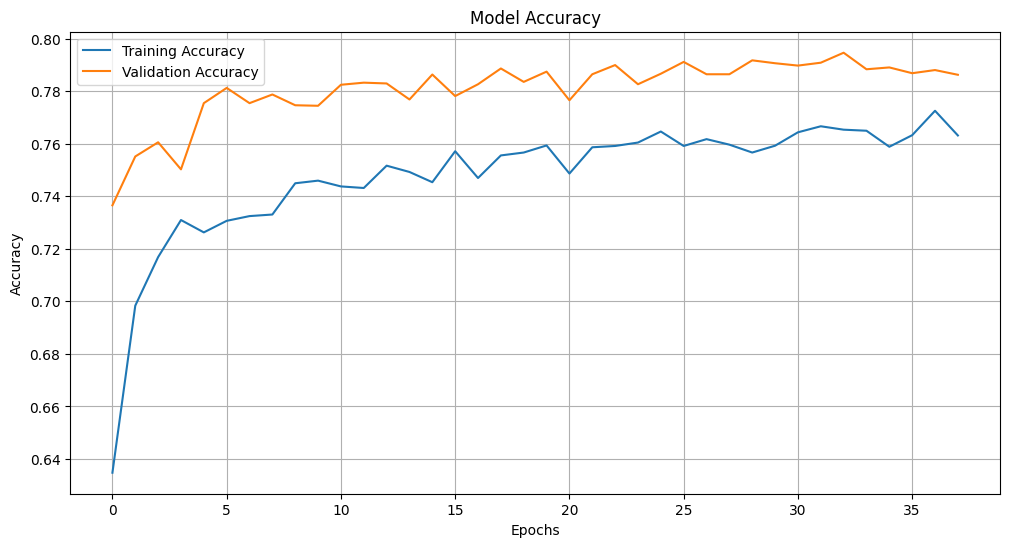

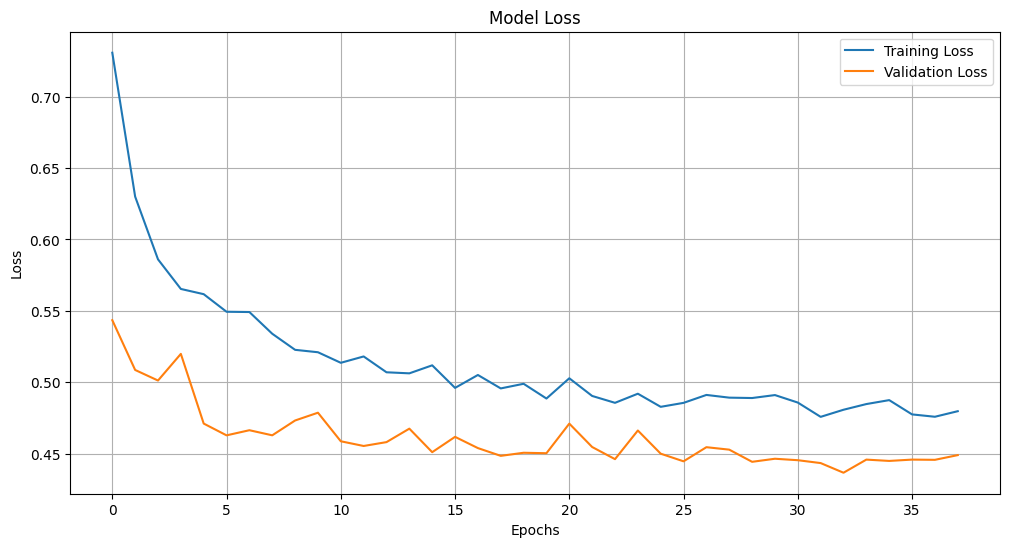

626/626 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step


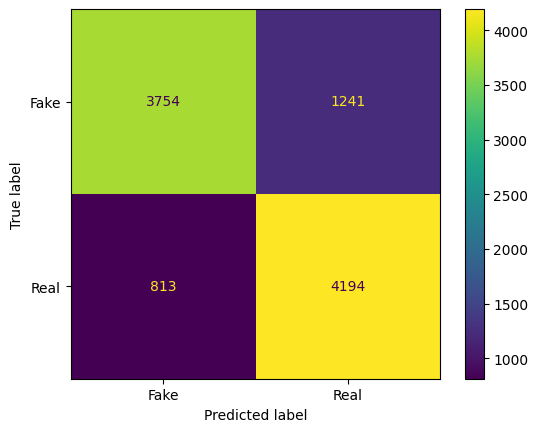

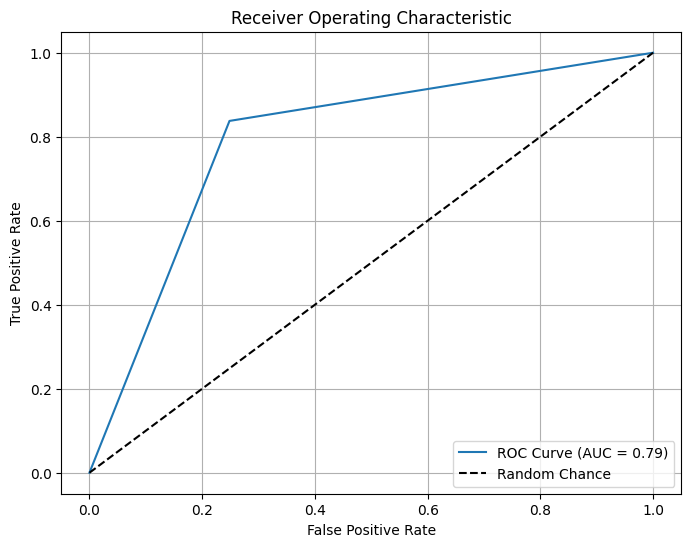

In [34]:
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import AdamW
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import numpy as np

# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
TRAIN_LIMIT = 1000
VALIDATION_LIMIT = 150
TEST_LIMIT = 150

# Function to limit data
def limit_data(directory, max_images):
    classes = os.listdir(directory)
    limited_dir = '/kaggle/working/limited_dataset'
    os.makedirs(limited_dir, exist_ok=True)
    
    for cls in classes:
        src_cls_path = os.path.join(directory, cls)
        dst_cls_path = os.path.join(limited_dir, cls)
        os.makedirs(dst_cls_path, exist_ok=True)
        
        all_images = os.listdir(src_cls_path)
        selected_images = random.sample(all_images, min(max_images, len(all_images)))
        
        for img in selected_images:
            src_path = os.path.join(src_cls_path, img)
            dst_path = os.path.join(dst_cls_path, img)
            if not os.path.exists(dst_path):
                os.symlink(src_path, dst_path)
    
    return limited_dir

# Paths
train_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Train'
val_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Validation'
test_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Test'

# Limit datasets
train_dir_limited = limit_data(train_dir, TRAIN_LIMIT)
val_dir_limited = limit_data(val_dir, VALIDATION_LIMIT)
test_dir_limited = limit_data(test_dir, TEST_LIMIT)

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip=True,
    rotation_range=40,
    zoom_range=0.3,
    shear_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir_limited,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

valid_generator = datagen.flow_from_directory(
    val_dir_limited,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    test_dir_limited,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Load the DenseNet121 base model
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model layers

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=AdamW(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

# Callbacks
checkpoint_path = "/kaggle/working/Best_Model.keras"
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50,
    callbacks=[model_checkpoint, lr_scheduler, early_stopping]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Generate confusion matrix
y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["Fake", "Real"])
disp.plot(cmap="viridis")
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
